<a href="https://colab.research.google.com/github/IamGrimbo/RUAP/blob/main/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/ferit-osirv/lab5/blob/main/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5 - Image Segmentation using Watershed

Ove laboratorijske vježbe se rješavaju u Google Colabu i spremaju na GitHub repozitorij koji je povezan na GitHub Classroom.

## Kako riješiti zadatke?

1. Prihvatite zadatak putem Google Classroom linka koji ćete dobiti. Google Classroom će kreirati repozitorij na vašem računu.
2. Uđite u novokreiran repozitorij na vašem računu i kliknite na **.ipynb** datoteku, zatim kliknite **Open in Colab**.
3. Zadatke rješavate u Google Colabu.

## Kako spremiti (predati) zadatke?

1. Unutar **Google Colaba** kliknite na **Open settings** kotačić u gornjem desnom kutu.
2. Kliknite na **GitHub** tab i odaberite kvačicu za **Access private repositories and organizations**.
3. Otvorit će se novi prozor da dodate pristup GitHubu. Kod **ferit-osirv** kliknite **Grant**.  
4. Spremite i izađite iz postavki.


5. Kliknite na **File > Save a copy in GitHub**.
6. Odaberite kreiran repozitorij labosa **koji uključuje vaše ime**.

> *Napomena:* Korake 1-4 morate napraviti samo prvi put.

## Kopiranje datoteka iz GitHub repozitorija

Za izradu vježbi bit će vam potrebne slike i druge datoteke koje će se nalaziti u GitHub repozitoriju vježbe. Ovakva komanda će biti dostupna u notebooku svake vježbe. Ona će kopirati datoteke s GitHuba u Google Colab okruženje.

**Ovu komandu je potrebno pokrenuti prije nego što krenete raditi svaku vježbu.**

In [ ]:
!rm -rf clone && git clone https://github.com/runsandshite/lab5 clone && cp -a clone/. .


Cloning into 'clone'...
remote: Enumerating objects: 14, done.
remote: Total 14 (delta 0), reused 0 (delta 0), pack-reused 14
Unpacking objects: 100% (14/14), done.


**Google Colab će povremeno obrisati sve datoteke.** Tako da će možda biti potrebno ponovno pokrenuti ovu komandu između dvije sesije. Ako dobivate greške da datoteke ne postoje, probajte ponovno pokrenuti gornju komandu.

## Introduction

Very simple segmentation methods like thresholding sometimes give good results, but as soon as we have more complex images, we need more complex algorithms. One problem that thresholding can't solve is to segment overlapping objects. In the cell image below, you'll notice a lot of the cells overlap and look like they are joined. To correctly segment them, we need an algorithm that is capable of separating overlapping objects. The watershed is a classical algorithm used for segmentation, that is, for separating different objects in an image.

In this lab, you'll implement a full watershed segmentation pipeline for segmenting blood cells from a microscope blood smear image (left).
Once you're done, you'll obtain an image similar to the one in the right.

[![image](https://www.linkpicture.com/q/watershed.png)](https://www.linkpicture.com/view.php?img=LPic61b78a27ee5251872959539)


### Watershed segmentation

The term watershed refers to a ridge that divides areas drained by different river systems. A catchment basin is the geographical area draining into a river or reservoir.

Any grayscale image can be viewed as a topographic surface where high intensity denotes peaks and hills while low intensity denotes valleys. You start filling every isolated valleys (local minima) with different colored water (labels). As the water rises, depending on the peaks (gradients) nearby, water from different valleys, obviously with different colors will start to merge. To avoid that, you build barriers in the locations where water merges. You continue the work of filling water and building barriers until all the peaks are under water. Then the barriers you created gives you the segmentation result. This is the "philosophy" behind the watershed.

Lets observe this in the following example. Any greytone image can be considered as a topographic surface:


![watershed1](https://people.cmm.minesparis.psl.eu/users/beucher/ima1.gif)
![watershed2](https://people.cmm.minesparis.psl.eu/users/beucher/ima2.gif)

If we flood this surface from its minima and, if we prevent the merging of the waters coming from different sources, we partition the image into two different sets: the catchment basins and the watershed lines.

![watershed3](https://people.cmm.minesparis.psl.eu/users/beucher/lpe1.gif)
![watershed4](https://people.cmm.minesparis.psl.eu/users/beucher/ima3.gif)

If we apply this transformation to the image gradient, the catchment basins should theoretically correspond to the homogeneous grey level regions of this image. However, in practice, this transform produces an important over-segmentation due to noise or local irregularities in the gradient image.

![watershed5](https://people.cmm.minesparis.psl.eu/users/beucher/ima6.gif)
![watershed6](https://people.cmm.minesparis.psl.eu/users/beucher/ima7.gif)
![watershed7](https://people.cmm.minesparis.psl.eu/users/beucher/ima7b.gif)


### Image preprocessing for watershed

#### Distance transform as preprocessing for watershed

To use watershed, you first need an image that you can treat as a smooth 3D topology map to pour water in. You can't use the original microscope image, instead, you need to convert it into a grayscale image where cells have light values and the background is black. To do this you'll use **distance transform**. Distance transform of a binary image (with pixel values 1 or 0) will give you an image where each pixel's value is the distance to its closest edge.


![distance_transform](https://gitlab.com/habijaaan/osirv_20_21/-/raw/master/lab6/distance_transform.jpg)


This way you transform a binary image into a smooth image where the distance to the edge is the "height" of the mountain.

#### Contrast Limited Adaptive Histogram Equalization (CLAHE)

Contrast Limited Adaptive Histogram Equalization or CLAHE is a technique for histogram equalization, improving the contrast of the image. Bright images have only light pixel values, while dark images have only dark pixel values. Histogram equalization stretches the histogram of an image so that its values span a broader range, making both dark and bright images have the same mean pixel value.

You'll use CLAHE as a preprocessing step for your algorithm. More info: https://docs.opencv.org/master/d5/daf/tutorial_py_histogram_equalization.html



#### Morphological operators for removing noise in images

Morphological operators take a binary image and a structuring element as input and combine them using a set operator (intersection, union, inclusion, complement). They process objects in the input image based on characteristics of its shape, which are encoded in the structuring element.

Usually, the structuring element is sized 3×3 and has its origin at the center pixel. It is shifted over the image and at each pixel of the image its elements are compared with the set of the underlying pixels. For the basic morphological operators the structuring element contains only foreground pixels (i.e. ones) and 'don't care's'. These operators, which are all a combination of erosion and dilation, are often used to select or suppress features of a certain shape, e.g. removing noise from images or selecting objects with a particular direction.
The more sophisticated operators take zeros as well as ones and 'don't care's' in the structuring element. The most general operator is the hit and miss, in fact, all the other morphological operators can be deduced from it. Its variations are often used to simplify the representation of objects in a binary image while preserving their structure, e.g. producing a skeleton of an object using skeletonization and tidying up the result using thinning.

The common morphological operations are:

*  Dilation - grow image regions
*  Erosion - shrinks image regions
*  Opening - structured removal of image region boundary pixels
*  Hit and miss transform - image pattern matching and marking
*  Thining - structured erosion using image pattern matching
*  Thickening - structured dilation using image pattern mathcinh
*  Skeletonization - finding skeletons of binary regions

You'll use morphological opening and dilation as a preprocessing step for your algorithm.
More info: https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html


# Watershed Segmentation steps

So, to segment your image, here's what you'll do:

1. Convert the microscope image into grayscale.
2. Perform CLAHE on the grayscale image to accentuate cell edges.
3. Threshold the image so you get a binary image where cells are white and the background is black.
4. Use morphological operators to remove noise from that binary image.
5. Use distance transform on the binary image.
6. Threshold the distance transform to obtain markers.
7. Apply watershed with the obtained markers to get the final segmentation.



#Assignments

Your assignment is to fill in code in the # TODO comments in the code.

1. Compare your saved images with the ones named <image>_example.png to make sure your code works.
2. Rename your result.png image into result_original.png. Then, comment out gray = clahe(gray).
3. Run the code again and compare the new result.png to your original one.
4. Add a comment at the bottom explaining what differences you see and why those differences are there.
5. Annotate your result image however you like (using any image editing tool) to show (a) one example of oversegmentation on the image and (b) one example of undersegmentation on the image.

In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import math
from google.colab.patches import cv2_imshow
import random as rng

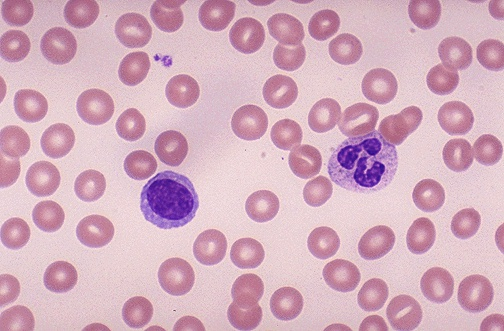

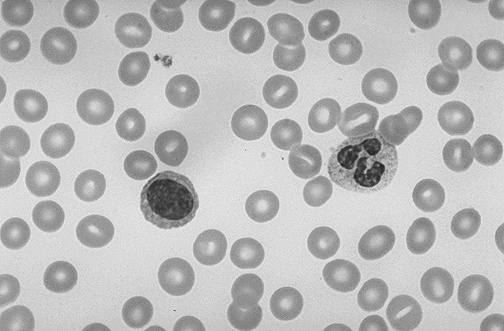

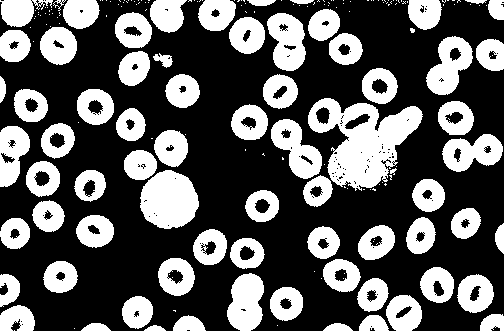

In [ ]:
# Load the source image
img = cv.imread('images/cells.jpg')
cv2_imshow(img)
# Convert image to grayscale
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
cv2_imshow(gray)
# Apply CLAHE
#gray = clahe(gray)
# OTSU threshold the image
#TODO:
thresh = cv.threshold(gray,180,255,cv.THRESH_BINARY_INV)
cv.imwrite("images/thresholded.png", thresh[1])
cv2_imshow(thresh[1])

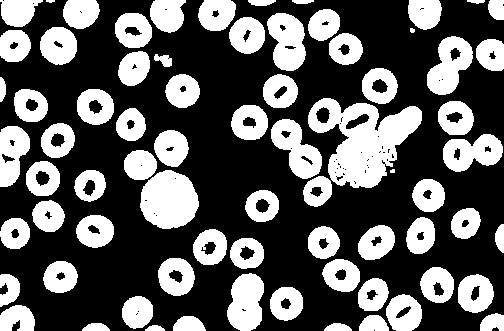

In [ ]:
# Use morphological processing to remove noise from the image
# use 3x3 structuring element and opening operations
#TODO:
kernel = np.ones((3,3),np.uint8)
#TODO:
opening = cv.morphologyEx(thresh[1], cv.MORPH_OPEN, kernel)
cv2_imshow(opening)

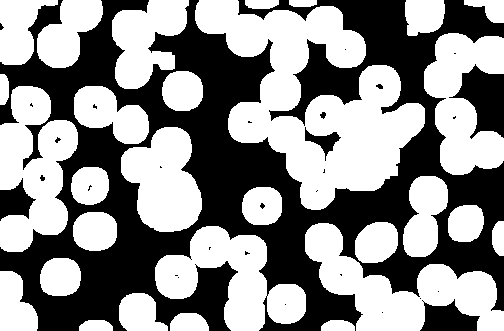

In [ ]:
# Finding sure background area
#TODO:
sure_bg = cv.dilate(opening,kernel,iterations=3)
cv2_imshow(sure_bg)

In [ ]:
# Apply distance transform the image
dist_transform =  cv.distanceTransform(opening, cv.DIST_L2, 3)
# Normalize so that the distance transform image has minimum and maximum values from 0 to 1
cv.normalize(dist_transform, dist_transform, 0, 1.0, cv.NORM_MINMAX)

array([[0.08353873, 0.08353873, 0.04176936, ..., 0.20331755, 0.1851975 ,
        0.16707745],
       [0.04176936, 0.04176936, 0.05988942, ..., 0.1615482 , 0.14342815,
        0.12530808],
       [0.        , 0.        , 0.04176936, ..., 0.11977883, 0.10165878,
        0.08353873],
       ...,
       [0.5012323 , 0.45946297, 0.41769361, ..., 0.14342815, 0.1851975 ,
        0.22696686],
       [0.5012323 , 0.45946297, 0.41769361, ..., 0.12530808, 0.16707745,
        0.20884681],
       [0.5012323 , 0.45946297, 0.41769361, ..., 0.12530808, 0.16707745,
        0.20884681]], dtype=float32)

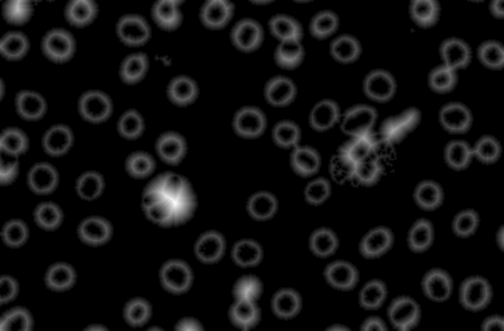

In [ ]:
#cv.imwrite("images/distance_transform.png", dist_transform * 255)
cv2_imshow(dist_transform*255)

In [ ]:
# Sure foreground area is where the distance transform has the highest values,
# so threshold the image so that every pixel below 0.2 is set to 0
ret, sure_fg = cv.threshold(dist_transform, 0.2*dist_transform.max(), 255, 0)

In [ ]:
# Finding unknown region, i.e. the difference between sure foreground and sure background (the edges of the cells)
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

In [ ]:
# Find areas of connected pixels - we call these markers
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all markers so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

In [ ]:
# Finally, apply watershed to the image using the markers as guides
markers = cv.watershed(img, markers)

In [ ]:
# Generate random colors
colors = []
for i in range(markers.shape[0] * markers.shape[1]):
  colors.append((rng.randint(0,256), rng.randint(0,256), rng.randint(0,256)))

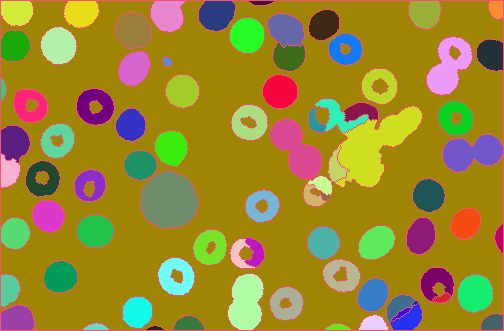

True

In [ ]:
# Create the result image
dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)
# Fill labeled objects with random colors
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        index = markers[i,j]
        dst[i,j,:] = colors[index-1]

cv2_imshow(dst)
cv.imwrite("images/result.png", dst)

Ne zaboravite spremiti zadatke na GitHub!